In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

In [3]:
def stack_arrays(a, keys, axis=-1):
    flat_arr = np.stack([a[k].flatten() for k in keys], axis=axis)
    return awkward.JaggedArray.fromcounts(a[keys[0]].counts, flat_arr)

In [4]:
def pad_array(a, maxlen, value=0., dtype='float32'):
    x = (np.ones((len(a), maxlen)) * value).astype(dtype)
    for idx, s in enumerate(a):
        if not len(s):
            continue
        trunc = s[:maxlen].astype(dtype)
        x[idx, :len(trunc)] = trunc
    return x

In [29]:
def preProcessData(data):
    # remove low-momentum jets
    good = data[data.p > 25]
    for particle_idx in range(50):
        # change to deltaEta (rel to jet axis)
        good.loc[:, "p" + str(particle_idx+1)+"eta"] = np.abs(good.eta - good["p" + str(particle_idx+1)+"eta"])
        # change to deltaPhi (rel to jet axis)
        good.loc[:, "p" + str(particle_idx+1)+"phi"] -= good.phi 
        good.loc[good["p" + str(particle_idx+1)+"phi"] <= -np.pi, "p" + str(particle_idx+1)+"phi"] += 2*np.pi
        good.loc[np.pi <= good["p" + str(particle_idx+1)+"phi"], "p" + str(particle_idx+1)+"phi"] -= 2*np.pi
        # change to Pfrac (rel to jet p)
        good.loc[:, "p" + str(particle_idx+1)+"p"] /= good.p 
    return good

In [34]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
class Dataset(object):
    def __init__(self, filepath, feature_dict = {}, label='label', pad_len=50, data_format='channel_first'):
        self.filepath = filepath
        self.feature_dict = feature_dict
        if len(feature_dict)==0:
            feature_dict['points'] = ['eta', 'phi']
            feature_dict['features'] = ['p', 'eta', 'phi']
            feature_dict['mask'] = ['p']
        self.label = label
        self.pad_len = pad_len
        assert data_format in ('channel_first', 'channel_last')
        self.stack_axis = 1 if data_format=='channel_first' else -1
        self._values = {}
        self._label = None
        self._load()

    def _load(self):
        logging.info('Start loading file %s' % self.filepath)
        data = pd.read_csv(self.filepath)
        # let's start with only "bb" and "uu"
        data = data[data.sampleType.isin(["bb", "uu"])]
        # change jet values to relative ones
        data = preProcessData(data)
        # we need to one-hot encode the labels
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(data[self.label].to_numpy())
        # binary encode
        onehot_encoder = OneHotEncoder(sparse=False)
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
        self._label = onehot_encoded
        
        # each particle has its own index (e.g. eta17), but we want to collect
        # them all in array with the same name (i.e., eta)
        for k in self.feature_dict:
            cols = self.feature_dict[k]
            if not isinstance(cols, (list, tuple)):
                cols = [cols]
            self._values[k] = np.zeros((len(self._label), self.pad_len, len(cols)))
#             arrs = []
            for col_idx, col in enumerate(cols):
                # the data for all particles for this column
#                 colArray = []
                for particle_idx in range(self.pad_len):
                    colname = "p" + str(particle_idx+1) + col
                    self._values[k][:, particle_idx, col_idx] = data[colname].to_numpy()
#             self._values[k] = np.stack(arrs, axis=self.stack_axis)
        logging.info('Finished loading file %s' % self.filepath)


    def __len__(self):
        return len(self._label)

    def __getitem__(self, key):
        if key==self.label:
            return self._label
        else:
            return self._values[key]
    
    @property
    def X(self):
        return self._values
    
    @property
    def y(self):
        return self._label

    def shuffle(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        shuffle_indices = np.arange(self.__len__())
        np.random.shuffle(shuffle_indices)
        for k in self._values:
            self._values[k] = self._values[k][shuffle_indices]
        self._label = self._label[shuffle_indices]

In [35]:
train_dataset = Dataset('../data/ILD_ParticleNet_MC_tagging_train.csv', label="sampleType", data_format='channel_last')
val_dataset = Dataset('../data/ILD_ParticleNet_MC_tagging_val.csv', label="sampleType", data_format='channel_last')

[2021-02-13 18:57:35,031] INFO: Start loading file ../data/ILD_ParticleNet_MC_tagging_train.csv
/home/jstrube/.local/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
[2021-02-13 18:57:49,227] INFO: Finished loading file ../data/ILD_ParticleNet_MC_tagging_train.csv
[2021-02-13 18:57:49,246] INFO: Start loading file ../data/ILD_ParticleNet_MC_tagging_val.csv
/home/jstrube/.local/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

In [36]:
num_classes = train_dataset.y.shape[1]
input_shapes = {k:train_dataset[k].shape[1:] for k in train_dataset.X}

print(num_classes)
print(input_shapes)
print(train_dataset["points"].shape)

2
{'points': (50, 2), 'features': (50, 3), 'mask': (50, 1)}
(157071, 50, 2)


In [37]:
train_dataset.y[0]

array([1., 0.])

(array([1.50169e+05, 5.98800e+03, 7.45000e+02, 1.05000e+02, 2.50000e+01,
        1.50000e+01, 1.10000e+01, 4.00000e+00, 5.00000e+00, 4.00000e+00]),
 array([1.82610898e-07, 3.62337774e-01, 7.24675366e-01, 1.08701296e+00,
        1.44935055e+00, 1.81168814e+00, 2.17402573e+00, 2.53636333e+00,
        2.89870092e+00, 3.26103851e+00, 3.62337610e+00]),
 <BarContainer object of 10 artists>)

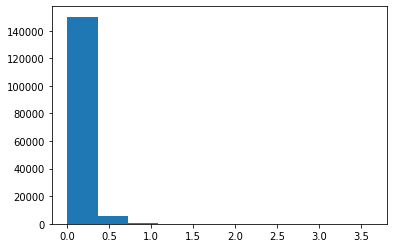

In [38]:
plt.hist(train_dataset["points"][:, 2, 0])

In [39]:
import tensorflow as tf
from tensorflow import keras
from tf_keras_model import get_particle_net, get_particle_net_lite

In [40]:
model_type = 'particle_net_lite' # choose between 'particle_net' and 'particle_net_lite'
# model_type = 'particle_net' # choose between 'particle_net' and 'particle_net_lite'
num_classes = train_dataset.y.shape[1]
input_shapes = {k:train_dataset[k].shape[1:] for k in train_dataset.X}
if 'lite' in model_type:
    model = get_particle_net_lite(num_classes, input_shapes)
else:
    model = get_particle_net(num_classes, input_shapes)

In [41]:
# Training parameters
batch_size = 1024 if 'lite' in model_type else 384

In [51]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 5:
        lr *= 0.1
    elif epoch > 10:
        lr *= 0.01
    logging.info('Learning rate: %f'%lr)
    return lr

In [48]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

[2021-02-13 19:02:00,770] INFO: Learning rate: 0.010000


Model: "ParticleNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mask (InputLayer)               [(None, 50, 1)]      0                                            
__________________________________________________________________________________________________
tf.math.not_equal_1 (TFOpLambda (None, 50, 1)        0           mask[0][0]                       
__________________________________________________________________________________________________
tf.cast_2 (TFOpLambda)          (None, 50, 1)        0           tf.math.not_equal_1[0][0]        
__________________________________________________________________________________________________
tf.math.equal_1 (TFOpLambda)    (None, 50, 1)        0           tf.cast_2[0][0]                  
________________________________________________________________________________________

In [52]:
# Prepare model model saving directory.
import os
save_dir = 'model_checkpoints'
model_name = 'ILC_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, lr_scheduler]

In [54]:
train_dataset.shuffle()
model.fit(train_dataset.X, train_dataset.y,
          batch_size=batch_size,
#           epochs=epochs,
          epochs=25, # --- train only for 1 epoch here for demonstration ---
          validation_data=(val_dataset.X, val_dataset.y),
          shuffle=True,
          callbacks=callbacks)

[2021-02-13 21:06:24,035] INFO: Learning rate: 0.001000


Epoch 1/25
127/154 [=======================>......] - ETA: 27s - loss: 0.5513 - accuracy: 0.7152

KeyboardInterrupt: 